In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import seaborn as sns
import cobra
import scipy.stats as st
import scipy
sys.path.append('../../code/')
import leakage
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer


/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_71800/1999822795.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
folder = Path('/Users/ssulheim/Library/CloudStorage/OneDrive-UniversitédeLausanne/UNIL/leakage/experimental work/sintef_sept_23/exometabolome')

In [3]:
fn = folder / 'SM_MPTA_Results.xlsx'
mapping_fn = folder / 'met_to_bigg.csv'
od_fn = folder / '..' / 'REL-F-U37-23_OD_TV.xlsx'

In [4]:
df_raw = pd.read_excel(fn, index_col=0)

In [5]:
df_raw

,anova.Class001.pValue,anova.Class001.pValueAdj,anova.Class003.pValue,anova.Class003.pValueAdj,anova.interaction.pValue,anova.interaction.pValueAdj,Unnamed: 7,Peak Area (Ion counts),Unnamed: 9,Unnamed: 10,...,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52
Metabolite,,,,,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,Class001,L-malate,L-alanine,L-malate,...,Galactose,L-alanine,L-alanine,L-alanine,L-alanine,L-alanine,Galactose,L-malate,L-malate,L-malate
NaN,NaN,NaN,NaN,NaN,NaN,NaN,Class002,T3,T2,T4,...,T4,T2,T1,T1,T0,T2,T2,T4,T2,T3
NaN,NaN,NaN,NaN,NaN,NaN,NaN,Class003,3,2,4,...,4,2,1,1,0,2,2,4,2,3
NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sample_ID,SM_MPTA_112023_49_L-malate-T10_M5_19,SM_MPTA_112023_79_L-alanine-T16_M9_28,SM_MPTA_112023_58_L-malate-T12_M5_22,...,SM_MPTA_112023_93_Galactose-T20_M3_12,SM_MPTA_112023_80_L-alanine-T16_M10_29,SM_MPTA_112023_53_L-alanine-T10_M10_26,SM_MPTA_112023_54_L-alanine-T10_M11_27,SM_MPTA_112023_M9 Alanine_002_38,SM_MPTA_112023_81_L-alanine-T16_M11_30,SM_MPTA_112023_66_Galactose-T14_M3_6,SM_MPTA_112023_143_L-malate-T13_M6_23,SM_MPTA_112023_127_L-malate-T9_M5_16,SM_MPTA_112023_51_L-malate-T10_M7_21
GLUTARYLCARNITINE (C5-DC),3.032482e-01,3.775130e-01,2.461088e-01,2.754612e-01,7.012446e-01,0.770737,NaN,165.47856,160.392441,124.590656,...,0.000157,526.144681,271.015868,448.720536,0.000165,249.851275,443.492334,676.771243,767.600005,863.253965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OROTATE,5.529773e-16,5.621936e-15,7.319848e-72,8.930215e-70,7.703948e-07,0.000006,NaN,7211594.047449,4458607.332537,7237280.648257,...,7184026.887254,4274832.798877,2532785.827348,2549118.452073,0.0001,4274329.682559,5923855.665037,7586518.325333,6941441.773588,7109571.673301
"2,5-DIHYDROXYBENZOATE",1.760302e-03,3.520603e-03,2.077279e-33,9.386225e-33,2.002389e-01,0.309230,NaN,77342.683223,37832.580734,86523.453373,...,38468.019538,23694.347389,15555.252093,19239.836465,0.0001,34284.559324,17918.071948,106153.390143,66821.349547,69106.003884
DIHYDROOROTATE,2.144789e-10,9.691267e-10,9.501414e-55,3.023415e-53,7.227727e-05,0.000284,NaN,989273.244708,449764.105517,1132433.620757,...,1517193.767485,446114.227177,115954.321478,105349.478037,0.000101,381229.529205,1390490.010275,1006911.711076,974965.527392,1013830.890168


In [6]:
df_metadata = df_raw.iloc[:4, 7:].T
df_data = df_raw.iloc[3:, 7:]

In [7]:
df_metadata.columns = ['Carbon source', 'Timepoint', 'Time', 'Sample ID']
df_metadata['Sample ID'] = [x.strip() for x in df_metadata['Sample ID']]

In [8]:
sample_id_to_cs = df_metadata.set_index('Sample ID')['Carbon source'].to_dict()
sample_id_to_t = df_metadata.set_index('Sample ID')['Time'].astype(int).to_dict()

In [9]:
df_data.columns = df_data.iloc[0,:].values

In [10]:
df_data = df_data.iloc[1:,:].T

In [11]:
df_data.columns = [x.strip() for x in df_data.columns]

In [12]:
df_data.drop(columns=['MALATE', 'HEXOSES including Glucose and Fructose', 'SUCCINATE', 'ALANINE'], inplace=True)

In [13]:
df_data.columns

Index(['GLUTARYLCARNITINE (C5-DC)', 'TRIGONELLINE', 'NICOTINAMIDE',
       'METHYLTHIOADENOSINE', 'ALPHA-AMINOADIPATE', 'CREATINE', 'CREATININE',
       'GLUTAMINE', '4-IMIDAZOLEACETATE', 'GLYCINE',
       ...
       'HOMOSERINE', 'UROCANATE', '3-HYDROXYANTHRANILATE', 'GLUCONOLACTONE',
       'ALLANTOIN', 'OROTATE', '2,5-DIHYDROXYBENZOATE', 'DIHYDROOROTATE',
       'URACIL', 'SALICYLATE'],
      dtype='object', length=118)

In [14]:
df_data

,GLUTARYLCARNITINE (C5-DC),TRIGONELLINE,NICOTINAMIDE,METHYLTHIOADENOSINE,ALPHA-AMINOADIPATE,CREATINE,CREATININE,GLUTAMINE,4-IMIDAZOLEACETATE,GLYCINE,...,HOMOSERINE,UROCANATE,3-HYDROXYANTHRANILATE,GLUCONOLACTONE,ALLANTOIN,OROTATE,"2,5-DIHYDROXYBENZOATE",DIHYDROOROTATE,URACIL,SALICYLATE
SM_MPTA_112023_49_L-malate-T10_M5_19,165.47856,533.9806,46728.369613,361405.926379,704.659411,0.0001,6191.442112,28190.928206,4151.774818,0.000091,...,988.402968,33473.971147,63736.440894,0.000096,428120.82441,7211594.047449,77342.683223,989273.244708,20438.195124,6478.470622
SM_MPTA_112023_79_L-alanine-T16_M9_28,160.392441,399.721802,16237.558902,399119.458719,627.893912,11396.316681,0.000142,4324.636996,4041.761658,7936.785374,...,23550.208923,27116.168344,37287.095607,283.992402,197105.160962,4458607.332537,37832.580734,449764.105517,8224.735053,4228.045899
SM_MPTA_112023_58_L-malate-T12_M5_22,124.590656,1743.213445,279292.11543,463243.046927,257.771996,2548.006846,9179.080763,3296.94398,2676.500018,0.000092,...,775.869912,35167.488893,79292.861334,0.000097,457527.818246,7237280.648257,86523.453373,1132433.620757,105335.605638,11085.564292
SM_MPTA_112023_28_Galactose-T6_M1_1,123.471379,1554.973324,99539.721715,63484.576879,0.000076,1151.434034,8239.458416,1145.893579,3494.686023,0.000093,...,0.000098,12501.967397,4811.389174,1371.717933,102768.554721,3099877.262256,9484.248734,192618.137821,0.000098,1149.212427
SM_MPTA_112023_ M9 Galactose_001_40,97.385959,2760.120639,182899.975162,0.000153,0.000078,860.278505,5428.853243,1025.615943,3555.865334,0.000093,...,0.000098,1601.121008,0.000104,0.000097,0.000103,0.000101,0.000101,0.000098,0.000098,1212.977369
SM_MPTA_112023_Â M9 Alanine_001_37,134.76927,314.855106,9586.678923,0.000149,0.000079,13602.167446,3893.263074,635.35025,0.000123,0.000094,...,0.000098,2119.038699,0.000104,0.000097,0.000103,0.000101,0.001008,0.000098,0.000099,795.03924
SM_MPTA_112023_ M9 Galactose_002_41,47.817917,1040.155712,404257.223813,0.000146,0.000081,1893.919382,7135.125438,668.620467,2847.253206,0.000094,...,0.000098,1452.947863,0.000104,0.000097,0.000102,0.000101,0.000101,0.000099,0.000099,2099.990629
SM_MPTA_112023_64_Galactose-T14_M1_7,276.066409,815.15331,62260.956364,365006.173808,379.9394,3114.473637,17535.048822,3215.854554,4476.504952,0.000095,...,0.000098,30444.378634,37623.212041,14859.045929,577538.676254,6540995.144008,33386.603251,1349530.635615,37317.055226,4918.439672
SM_MPTA_112023_52_L-alanine-T10_M9_25,92.414936,448.049434,24143.59322,139787.613207,208.098855,13044.391192,7356.812312,3246.267157,3040.118989,3718.182738,...,8047.573932,11698.694103,9495.650447,0.000098,54000.624293,2588892.385896,18176.953347,118327.241488,95.892629,1447.802388
SM_MPTA_112023_32_L-malate-T6_M6_14,415.740767,473.499691,22170.768761,57613.988011,0.000088,1668.415616,0.000113,8502.901934,2449.637477,0.000096,...,143.05021,12228.033273,7400.270607,0.000098,61247.170928,3187933.313094,16241.722835,157382.331174,0.000099,2257.218453


### PCA

[0.33950718 0.1528132  0.11556114 0.08288456]


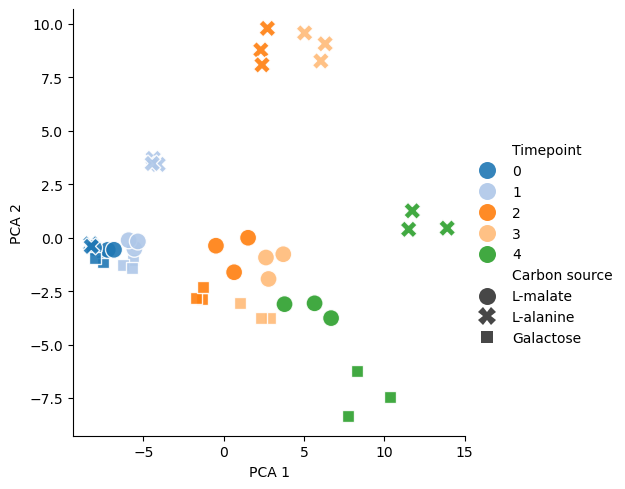

<Figure size 640x480 with 0 Axes>

In [34]:
pca = PCA(n_components=4)
X = df_data
X_std =X.std(axis=0)
X_std[X_std==0]=1
Xi = (X-X.mean(axis = 0))/X_std
Xi.fillna(0, inplace=True)
# Xi.fillna(Xi.min(axis=0), inplace=True)
# imputer = SimpleImputer()
# Xi = imputer.fit_transform(X)
fit = pca.fit(Xi)
fitT = pca.fit_transform(Xi)
print(fit.explained_variance_ratio_)
pca_df_s = pd.DataFrame(fitT, columns = ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4'])
pca_df_s['SID'] = Xi.index
# pca_df_s['Strain'] = pca_df_s['SID'].map(cid_dict_s)
pca_df_s['Carbon source'] = pca_df_s['SID'].map(sample_id_to_cs)
pca_df_s['Timepoint'] = pca_df_s['SID'].map(sample_id_to_t)

# pca_df_s['Type'] = pca_df_s['SID'].map(cid_dict_t)
# pca_df_s['OD'] = [cid_strain_cs_od[strain, met] for met in pca_df_s['Carbon_Source']]
# df_list.append(pca_df_s)

# pca_df = pd.concat(df_list)
sns.relplot(data = pca_df_s, x = 'PCA 1', y = 'PCA 2', style = 'Carbon source', hue = 'Timepoint', palette='tab20', s = 150, facet_kws={'sharey': False, 'sharex': False}, alpha = 0.9)#, hue_order=['S','A'])
plt.show()
plt.savefig('pca_untargeted_sintef_23.pdf')